In [1]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid

from qutip import mesolve, tensor, qeye, destroy

%cd ".."

from src.modules.cavity import cav_collapse_ops
from src.modules.simulation import Simulation
from src.modules.laser_pulses import create_masked
from src.modules.correlation_functions import rho_evo_fixed_start, exp_eval_floating_start_finish


/Users/janoleernst/Desktop/DPhil/Simulations/Code/rb_photon_prod_dev_git/rb_photon_prod_dev


/Users/janoleernst/anaconda3/envs/qutip5/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [2]:
_ground_states = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}

# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels

_x_states = [
'x0',
'x1M','x1','x1P',
'x2MM',
'x2M','x2','x2P',
'x2PP',
'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
'x1M_d1','x1_d1','x1P_d1',
'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]


rb_atom_sim = Simulation(cavity=True, bfieldsplit="0",ground_states=_ground_states, x_states=_x_states, show_details=True)

Atom-cavity coupling in 0 MHz split hyperfine states is: gLev=9.928MHz
This corresponds to a cooperativity of C=7.822857142857144, with theoretical upper bound in photon production efficiency of eta=0.9399244764847237


In [3]:
#define list of collapse operators
c_op_list=[]
c_op_list+= cav_collapse_ops(rb_atom_sim.kappa, _ground_states)

#by default we are adding the collapse operators for both the d2 and d1 line, but comment out either if only one is desired
c_op_list += rb_atom_sim.rb_atom.spont_em_ops(_ground_states)[0] #d2 line
c_op_list+=rb_atom_sim.rb_atom.spont_em_ops(_ground_states)[1] #d1 line

In [4]:
# Rotation parameters - only values that differ between rotations
rotation_params = {
    3: {"param_1": 14.92, "laser_amplitude": 1459, "detuning": -33.82, "rotation_number": 3},
    4: {"param_1": 14.53, "laser_amplitude": 1139, "detuning": -40.28, "rotation_number": 4}
}

# Common parameters for all rotations
common_params = {
    "duration": 0.25, "detuning_magn": 1, "_n": 6, "_c": 0.25/3, "pulse_shape": "masked"
}

# Merge common params with specific params
third_params = {**common_params, **rotation_params[3]}
fourth_params = {**common_params, **rotation_params[4]}

# Rotation configurations
def create_rotation_config(states, deltas, cgs, pols):
    return {
        "psi_init": 1/np.sqrt(2)*(rb_atom_sim.kb_class.get_ket('g2PP',0,0)-rb_atom_sim.kb_class.get_ket('g2MM',0,0)),
        "psi_des": 1/np.sqrt(2)*(rb_atom_sim.kb_class.get_ket('g2PP',0,0)-rb_atom_sim.kb_class.get_ket(states["final"],0,0)),
        "state_i": states["initial"], "F_i": 2,
        "state_f": states["final"], "F_f": 1,
        "state_x": states["excited"], "F_x": 1,
        "delta_p": deltas[0], "delta_s": deltas[1],
        "cg_pump": cgs[0], "cg_stokes": cgs[1],
        "pump_pol": pols[0], "stokes_pol": pols[1]
    }

# Third rotation config
deltaZ = rb_atom_sim.get_splitting("deltaZ")
rotation_dict_3 = create_rotation_config(
    {"initial": "g2MM", "final": "g1M", "excited": "x1M_d1"},
    [rb_atom_sim.get_splitting("deltaZx1M_d1")+2*deltaZ, -deltaZ+rb_atom_sim.get_splitting("deltaZx1M_d1")],
    ["CG_d1g2MMx1M", "CG_d1g1Mx1M"],
    ["sigmaP", "pi"]
)

# Fourth rotation config  
rotation_dict_4 = create_rotation_config(
    {"initial": "g2PP", "final": "g1P", "excited": "x1P_d1"},
    [rb_atom_sim.get_splitting("deltaZx1P_d1")-2*deltaZ, deltaZ+rb_atom_sim.get_splitting("deltaZx1P_d1")],
    ["CG_d1g2PPx1P", "CG_d1g1Px1P"],
    ["sigmaM", "pi"]
)

# Fixed params
a = 1/np.sqrt(2)
b = 1/(2*np.pi)
lengthStirap = 0.5
delta_VST = 0
deltaZx2MM = rb_atom_sim.get_splitting("deltaZx2MM")
deltaZx2PP = rb_atom_sim.get_splitting("deltaZx2PP")
delta_cav = 2*deltaZ + deltaZx2MM + delta_VST

In [5]:
#VST PARAMS
delta_VST=0*2*np.pi
delta_cav =2*deltaZ+deltaZx2MM+delta_VST
delta_vst_laser_1=-deltaZ+deltaZx2MM+delta_VST
delta_vst_laser_2=deltaZ+deltaZx2PP+delta_VST
g_mhz = np.round(rb_atom_sim.coupling_factor,3)
F_vst_start=1
F_vst_final=2
F_vst_exc= 2
n_steps_vst=5000

# Define the pulse length and the number of time steps to be used in the simulation 
pulse_len = 0.5
OmegaStirap = 70*2*np.pi

wStirap = np.pi/pulse_len
def amp_shape(t):
    return np.sin(wStirap*t)**2

t_vst = np.linspace(0, pulse_len, n_steps_vst)
vst_driving_array = np.array(amp_shape(t_vst))

H_VStirap_1, args_hams_VStirap_1 = rb_atom_sim.gen_vstirap(lengthStirap, OmegaStirap, delta_vst_laser_1, "sigmaM",
                                                             delta_cav, vst_driving_array, F_start=1, F_exc=2, F_end=2)
H_VStirap_2, args_hams_VStirap_2 = rb_atom_sim.gen_vstirap(lengthStirap, OmegaStirap, delta_vst_laser_2, "sigmaP",
                                                             delta_cav, vst_driving_array, F_start=1, F_exc=2, F_end=2)

In [6]:
# Setup rotation 3
def setup_rotation(params_dict, rotation_dict, rotation_num):
    # Extract parameters
    _a = params_dict["param_1"]
    laser_amp = params_dict["laser_amplitude"]
    const_det = params_dict["detuning"]
    _length_repump = params_dict["duration"]
    _n, _c = params_dict["_n"], params_dict["_c"]
    
    # Get CG coefficients and calculate amplitudes
    cg_pump = rb_atom_sim.get_CG(rotation_dict["cg_pump"])
    cg_stokes = rb_atom_sim.get_CG(rotation_dict["cg_stokes"])
    pump_amp = laser_amp / cg_pump
    stokes_amp = laser_amp / cg_stokes
    
    # Time arrays
    n_steps = 2500
    t_rot = np.linspace(0, _length_repump, n_steps)
    
    # Generate pulses
    pump_pulse, stokes_pulse = create_masked(t_rot, pump_amp, stokes_amp, _a, n=_n, c=_c)
    pump_det = stokes_det = np.ones_like(pump_pulse)
    
    # Generate Hamiltonian
    H_rot, args_hams = rb_atom_sim.gen_repreparation(
        const_det, t_rot, rotation_dict["delta_p"], rotation_dict["delta_s"],
        rotation_dict["pump_pol"], rotation_dict["stokes_pol"], pump_pulse, stokes_pulse,
        rotation_dict["F_i"], rotation_dict["F_x"], rotation_dict["F_f"], rotation_dict["F_x"],
        pump_det=pump_det, stokes_det=stokes_det, raman_pulses=False, include_cavity=False
    )
    
    return H_rot, args_hams, t_rot, rotation_dict

# Setup both rotations
H_rot_3, args_hams_rot3, t_rot3, params_3 = setup_rotation(third_params, rotation_dict_3, 3)
psi_des = params_3["psi_des"]
rho_des = psi_des * psi_des.dag()

In [7]:
# Setup rotation 4
H_rot_4, args_hams_rot4, t_rot4, params_4 = setup_rotation(fourth_params, rotation_dict_4, 4)
psi_des_4 = params_4["psi_des"]

In [ ]:
#truncating Fock states
N=2
M=len(_ground_states)
# Create the photon operators
aX = tensor(qeye(M), destroy(N), qeye(N))
aY = tensor(qeye(M), qeye(N), destroy(N))
anX = aX.dag()*aX
anY = aY.dag()*aY

: 

In [ ]:
psi0 = 1/(np.sqrt(2))*(rb_atom_sim.kb_class.get_ket('g2PP',0,0)-rb_atom_sim.kb_class.get_ket('g1M',0,0))
H_list = [H_VStirap_1, H_rot_4, H_VStirap_2, H_rot_3]
H_sim_time_list=[t_vst, t_rot4, t_vst, t_rot3]

t_correlator_eval=np.linspace(0.0,0.75,20)
t_bin=np.array(0.75)

rho_start_list = rho_evo_fixed_start(H_list, H_sim_time_list, psi0,
                                     t_correlator_eval, c_op_list, 1, 1)

rho_start_list.insert(0,psi0*psi0.dag())

exp_values_diag_zero=mesolve(H_VStirap_1,psi0*psi0.dag(), t_vst, c_op_list, [anY]).expect[0]
exp_values_diag_one=mesolve(H_VStirap_2, rho_start_list[-1], t_vst, c_op_list, [anY]).expect[0]


In [ ]:
exp_values_off_diag_zero=[]
exp_values_off_diag_one=[]


for j, t2 in enumerate(t_correlator_eval):
    exp_off_diag_one = exp_eval_floating_start_finish(H_list, H_sim_time_list,
                                                    rho_start_list[j], t2,
                                                    [t2 + t_bin], c_op_list,1,aY.dag(),
                                                    aY)
    exp_values_off_diag_one.append(exp_off_diag_one[-1])

    exp_off_diag_zero = exp_eval_floating_start_finish(H_list, H_sim_time_list,
                                                    rho_start_list[j], t2,
                                                    [t2 + t_bin], c_op_list,aY,1,
                                                    aY.dag())
    exp_values_off_diag_zero.append(exp_off_diag_zero[-1])

Time exp_eval_floating_start_finish() simulation took: 0.9513020515441895
Time exp_eval_floating_start_finish() simulation took: 0.6637191772460938
Time exp_eval_floating_start_finish() simulation took: 4.647287130355835
Time exp_eval_floating_start_finish() simulation took: 4.660259008407593
Time exp_eval_floating_start_finish() simulation took: 5.453361749649048
Time exp_eval_floating_start_finish() simulation took: 5.369187116622925
Time exp_eval_floating_start_finish() simulation took: 5.062488079071045
Time exp_eval_floating_start_finish() simulation took: 5.062252044677734
Time exp_eval_floating_start_finish() simulation took: 4.714970111846924
Time exp_eval_floating_start_finish() simulation took: 4.6444971561431885
Time exp_eval_floating_start_finish() simulation took: 4.4293129444122314
Time exp_eval_floating_start_finish() simulation took: 4.483851909637451
Time exp_eval_floating_start_finish() simulation took: 4.446038007736206
Time exp_eval_floating_start_finish() simulatio

In [ ]:
# Integrate the real and imaginary parts
def integrate_real_imaginary(time_points, values):
    if len(time_points) != len(values):
        raise ValueError("Length of time_points and values must be equal")
    real_part = np.real(values)
    imag_part = np.imag(values)
    real_integral = trapezoid(real_part, time_points)
    imag_integral = trapezoid(imag_part, time_points)
    return real_integral, imag_integral

# Calculate integrals
int_diag_one_re, int_diag_one_im = integrate_real_imaginary(t_vst, exp_values_diag_one)
int_diag_zero_re, int_diag_zero_im = integrate_real_imaginary(t_vst, exp_values_diag_zero)
int_off_diag_one_re, int_off_diag_one_im = integrate_real_imaginary(t_correlator_eval, exp_values_off_diag_one)
int_off_diag_zero_re, int_off_diag_zero_im = integrate_real_imaginary(t_correlator_eval, exp_values_off_diag_zero)

print("Integral of rho_00 (Real, Imaginary):", int_diag_zero_re, int_diag_zero_im)
print("Integral of rho_11 (Real, Imaginary):", int_diag_one_re, int_diag_one_im)
print("Integral of rho_01 (Real, Imaginary):", int_off_diag_one_re, int_off_diag_one_im)
print("Integral of rho_10 (Real, Imaginary):", int_off_diag_zero_re, int_off_diag_zero_im)

Integral of rho_00 (Real, Imaginary): 0.01553876517968646 0.0
Integral of rho_11 (Real, Imaginary): 0.015491779623553569 0.0
Integral of rho_01 (Real, Imaginary): 0.007255063595775783 0.004393601954325148
Integral of rho_10 (Real, Imaginary): 0.007255063595762958 -0.004393601954489865


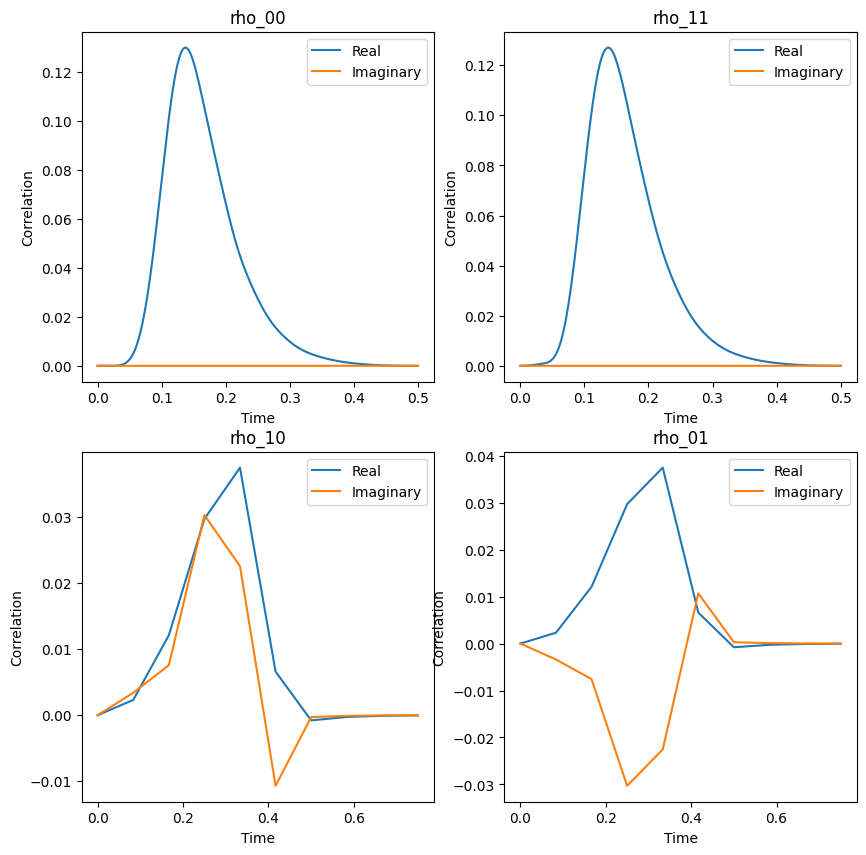

In [ ]:
#subsplot which plots the real and imaginary part fo the correlation functions:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 1].plot(t_vst, np.real(exp_values_diag_one), label='Real')
ax[0, 1].plot(t_vst, np.imag(exp_values_diag_one), label='Imaginary')
ax[0, 1].set_title('rho_11')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Correlation')
ax[0, 1].legend()

ax[0, 0].plot(t_vst, np.real(exp_values_diag_zero), label='Real')
ax[0, 0].plot(t_vst, np.imag(exp_values_diag_zero), label='Imaginary')
ax[0, 0].set_title('rho_00')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Correlation')
ax[0, 0].legend()

ax[1, 0].plot(t_correlator_eval, np.real(exp_values_off_diag_one), label='Real')
ax[1, 0].plot(t_correlator_eval, np.imag(exp_values_off_diag_one), label='Imaginary')
ax[1, 0].set_title('rho_10')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Correlation')
ax[1, 0].legend()

ax[1, 1].plot(t_correlator_eval, np.real(exp_values_off_diag_zero), label='Real')
ax[1, 1].plot(t_correlator_eval, np.imag(exp_values_off_diag_zero), label='Imaginary')
ax[1, 1].set_title('rho_01')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Correlation')
ax[1, 1].legend()